In [32]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from scipy.stats import median_abs_deviation

In [38]:
# Load data
data_sara_vacuum_raw = pd.read_csv('data/sara_vacuum.csv')[50:-100]
data_sara_picking_raw = pd.read_csv('data/sara_picking.csv')[50:-100]
data_sara_walking_raw = pd.read_csv('data/sara_walking.csv')[50:-100]

# Columns to pick
colnames_original = ["ACCELEROMETER X (m/s²)",
            "ACCELEROMETER Y (m/s²)",
            "ACCELEROMETER Z (m/s²)",
            "GYROSCOPE X (rad/s)",
            "GYROSCOPE Y (rad/s)",
            "GYROSCOPE Z (rad/s)",
            "GRAVITY X (m/s²)",
            "GRAVITY Y (m/s²)",
            "GRAVITY Z (m/s²)"]

# Pick relevant variables
data_sara_vacuum = data_sara_vacuum_raw[colnames_original]
data_sara_picking = data_sara_picking_raw[colnames_original]
data_sara_walking = data_sara_walking_raw[colnames_original]

# New column names
colnames = ['accelerometer_x',
            'accelerometer_y',
            'accelerometer_z',
            'gyroscope_x',
            'gyroscope_y',
            'gyroscope_z',
            'gravity_x',
            'gravity_y',
            'gravity_z']

colnames_dict = dict(zip(colnames_original, colnames))

# Changing column names
data_sara_vacuum.rename(columns = colnames_dict, inplace = True)
data_sara_picking.rename(columns = colnames_dict, inplace = True)
data_sara_walking.rename(columns = colnames_dict, inplace = True)

/Users/Sara/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
# Scale data
scl = StandardScaler()
data_sara_vacuum = scl.fit_transform(data_sara_vacuum)
data_sara_picking = scl.fit_transform(data_sara_picking)
data_sara_walking = scl.fit_transform(data_sara_walking)

In [40]:
# Function for merging observations

def merge_observations(data, seconds = 10):
    
    # Check if we can divide data evenly, otherwise cut data
    if (len(data) % seconds != 0):
        rows_to_remove = len(data) % seconds
        data = np.array(data[:-rows_to_remove])
        
    # Reshape into batches of observations to be merged
    data_reshaped = data.reshape(np.int(len(data)/seconds), seconds, data.shape[1])
    
    # Calculate agregated measures
    means = []
    stdevs = []
    mins = []
    maxs = []
    mads = []

    for i in range(len(data_reshaped)):
        means.append(data_reshaped[i].mean(axis = 0))
        stdevs.append(data_reshaped[i].std(axis = 0))
        mins.append(data_reshaped[i].min(axis = 0))
        maxs.append(data_reshaped[i].max(axis = 0))
        mads.append(median_abs_deviation(data_reshaped[0]))
        
    # Define columns names
    colnames_means = []
    colnames_stdevs = []
    colnames_mins = []
    colnames_maxs = []
    colnames_mads = []
    for i in range(len(colnames)):
        colnames_means.append(colnames[i] + '_mean')
        colnames_stdevs.append(colnames[i] + '_std')
        colnames_mins.append(colnames[i] + '_min')
        colnames_maxs.append(colnames[i] + '_max')
        colnames_mads.append(colnames[i] + '_mad')
    
    # Create dataframes
    df_mean = pd.DataFrame(stdevs, columns = colnames_means)
    df_std = pd.DataFrame(stdevs, columns = colnames_stdevs)
    df_min = pd.DataFrame(stdevs, columns = colnames_mins)
    df_max = pd.DataFrame(stdevs, columns = colnames_maxs)
    df_mad = pd.DataFrame(stdevs, columns = colnames_mads)
    
    # Merge dataframes
    dataframe_final = pd.concat([df_mean, df_std, df_min, df_max, df_mad], axis = 1)
    
    return dataframe_final

In [41]:
# Merge observations - 1 second per observation
data_sara_vacuum_merge = merge_observations(data_sara_vacuum)
data_sara_picking_merge = merge_observations(data_sara_picking)
data_sara_walking_merge = merge_observations(data_sara_walking)

In [52]:
# Label function
def check_threshold(accelerometer_y):
    activity = 'walking'
    if np.abs(accelerometer_y) > 0.5:
        activity = 'picking'
    return activity

In [53]:
# Label data
data_sara_picking_merge['activity'] = data_sara_picking_merge['accelerometer_y_mean'].apply(check_threshold)
data_sara_vacuum_merge['activity'] = 'vacuum'
data_sara_walking_merge['activity'] = 'walking'

In [54]:
# Add to one dataframe
data = pd.concat([data_sara_picking_merge,
                 data_sara_vacuum_merge,
                 data_sara_walking_merge], axis = 0)

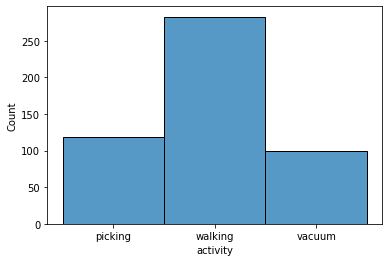

In [55]:
# Check distribution of activities
sns.histplot(x = 'activity', data = data)

In [56]:
# Separate labels and features
y = data['activity']
x = data.drop(labels = 'activity', axis = 1)

In [57]:
# Reduce dimensions
pca = PCA(n_components = 2, random_state = 42)
x_2 = pca.fit_transform(x)

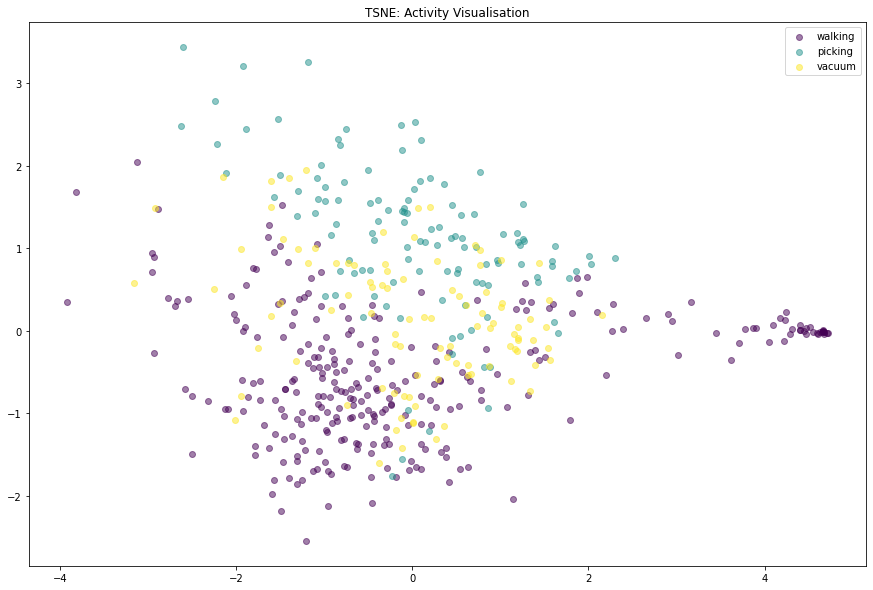

In [58]:
# Subplot
fig, axarr = plt.subplots(1, 1, figsize =(15, 10))

n = y.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(y.value_counts().index):
    # Mask to separate sets
    mask = (y==group).values
    axarr.scatter(x=x_2[mask][:,0], y=x_2[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('TSNE: Activity Visualisation')
axarr.legend()

plt.show()

In [59]:
# Reduce dimensions
pca = PCA(n_components = 0.9, random_state = 42)
x_3 = pca.fit_transform(x)

# Transform
tsne = TSNE(random_state = 42)
x_transformed = tsne.fit_transform(x_3)

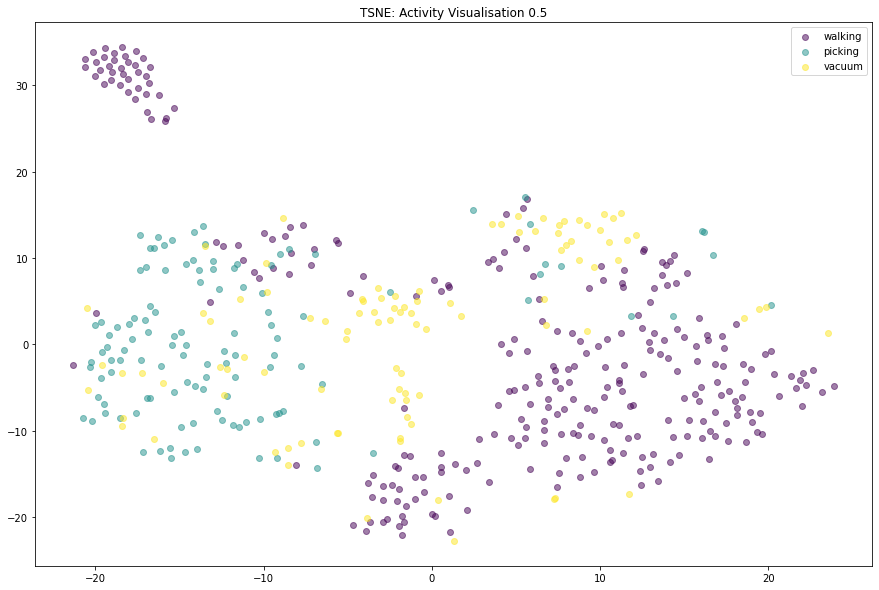

In [60]:
# Subplot
fig, axarr = plt.subplots(1, 1, figsize =(15, 10))

n = y.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(y.value_counts().index):
    # Mask to separate sets
    mask = (y==group).values
    axarr.scatter(x=x_transformed[mask][:,0], y=x_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('TSNE: Activity Visualisation 0.5')
axarr.legend()

plt.show()

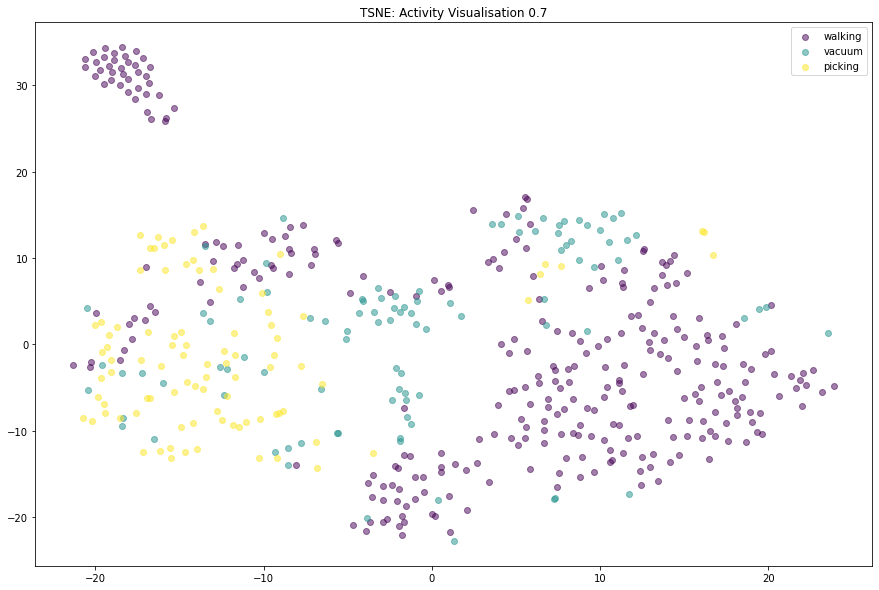

In [51]:
# Subplot
fig, axarr = plt.subplots(1, 1, figsize =(15, 10))

n = y.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(y.value_counts().index):
    # Mask to separate sets
    mask = (y==group).values
    axarr.scatter(x=x_transformed[mask][:,0], y=x_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('TSNE: Activity Visualisation 0.7')
axarr.legend()

plt.show()

In [61]:
# LGBM Classifier
enc = LabelEncoder()
label_encoded = enc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(x, label_encoded, random_state = 42)

# Create model
lgbm = LGBMClassifier(n_estimators = 500, random_state = 42)
lgbm = lgbm.fit(X_train, y_train)

# Test model
score = accuracy_score(y_true = y_test, y_pred = lgbm.predict(X_test))

In [62]:
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.8889



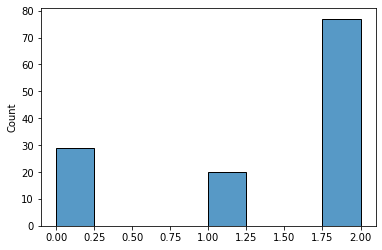

In [85]:
sns.histplot(data = y_test)

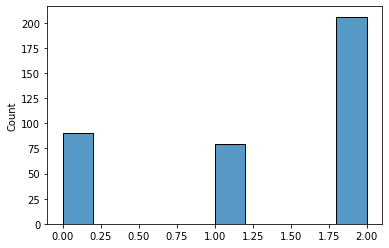

In [86]:
sns.histplot(data = y_train)

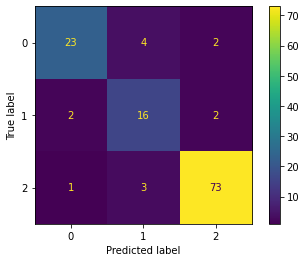

In [88]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lgbm, X_test, y_test)

In [90]:
enc.classes_

array(['picking', 'vacuum', 'walking'], dtype=object)

In [91]:
# Bäst på walking, sämst på vacuum

In [92]:
# Oversampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
x_ros, y_ros = ros.fit_sample(x, y)

ModuleNotFoundError: No module named 'imblearn'